In [1]:
import pandas as pd
from datetime import date, timedelta
import win32com.client as win32
import teradatasql
import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt
import pygwalker as pyg
import folium 
from folium.plugins import MarkerCluster, HeatMap
import requests
from xml.etree import ElementTree
import numpy as np

In [2]:
user="vitaly.flerin"
password="**"
query = '''select * from uat_ca.vf_rostov_research_052023'''

In [3]:
with teradatasql.connect(host="td2800.corp.tele2.ru", user=user, password=password,logmech="ldap", tmode="TERA" ) as connect:
    df = pd.read_sql(query, connect)
df

c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,subs_id,sector_name,BS_POSITION,coeff_80,top_3,coeff_80_new,LON,LAT,ST_POINT
0,69550762.0,RO4440_7,POINT (39.870024 47.275625),0.024720,2,2.47197980900596E-002,39.870024,47.275625,POINT (39.870024 47.275625)
1,58884985.0,RO0108_013,POINT (39.701917 47.133167),0.005736,1,5.73630510824610E-003,39.701917,47.133167,POINT (39.701917 47.133167)
2,49028625.0,RO0046_016,POINT (39.811944 47.237333),0.007292,3,7.29195748627168E-003,39.811944,47.237333,POINT (39.811944 47.237333)
3,33686957.0,RO0540_082,POINT (40.084222 47.406389),0.178033,1,1.78032734327038E-001,40.084222,47.406389,POINT (40.084222 47.406389)
4,36561037.0,RO3075_9,POINT (39.743861 47.25125),0.105827,1,1.05827183878443E-001,39.743861,47.251250,POINT (39.743861 47.25125)
...,...,...,...,...,...,...,...,...,...
264883,60721415.0,RO4396_1,POINT (39.670935 47.117836),0.010409,1,1.04085860444063E-002,39.670935,47.117836,POINT (39.670935 47.117836)
264884,10310023.0,RO3433_8,POINT (38.895306 47.2615),0.045467,2,4.54674921291119E-002,38.895306,47.261500,POINT (38.895306 47.2615)
264885,62477771.0,RO1183_082,POINT (40.095603 47.42476),0.003378,2,3.37781913851774E-003,40.095603,47.424760,POINT (40.095603 47.42476)
264886,62477771.0,RO1183_012,POINT (40.095603 47.42476),0.002126,3,2.12579371566479E-003,40.095603,47.424760,POINT (40.095603 47.42476)


<AxesSubplot:xlabel='LON', ylabel='LAT'>

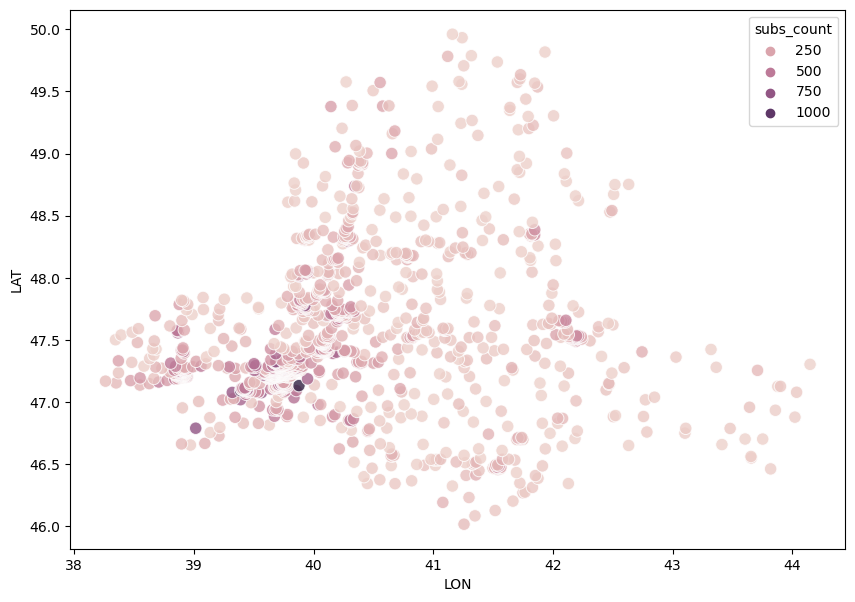

In [4]:
# Создаем датафрейм для распределения подписчиков по регионам
df_subs_count = df.groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})

# Создаем scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_subs_count, x='LON', y='LAT', hue='subs_count', cmap='cool', s=80, alpha=0.8)


In [ ]:
df_subs_count.sort_values(by = 'subs_count', ascending=False).head(10)

In [77]:
#добавляем интерактив
# Создаем датафрейм, группируем абонентов по локациям
df_subs_count = df.groupby(['LAT', 'LON','ST_POINT' ], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})
# Создаем карту
m = folium.Map(location=[df_subs_count['LAT'].mean(), df_subs_count['LON'].mean()], zoom_start=5)
# Создаем точечные маркеры для каждой точки и добавляем их на карту
for i, row in df_subs_count.iterrows():
    if row['subs_count'] > 1000:
        color = 'red'
    elif row['subs_count'] > 700 and row['subs_count'] < 1000:
        color = 'blue'
    else:
        color = 'green'
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=row['subs_count']/50,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=str(row['subs_count'])
    ).add_to(m)
m#.save("map.html")

In [ ]:
#тепловая в.1
locationlist = df[['LAT', 'LON']].values.tolist()
map3 = folium.Map(location=[55.62252, 37.30162], tiles='CartoDB dark_matter', zoom_start=5)
heat_df = df[['LAT', 'LON']]
heat_data = [[row['LAT'],row['LON']] for index, row in heat_df.iterrows()]
# Изменяем настройки цветовой схемы, используя параметр gradient
HeatMap(heat_data, radius=15, gradient={.1: 'blue', .2: 'lime', 1: 'red'}).add_to(map3)
map3

In [87]:
# создаем список координат из df 
#Это строка кода создает список координат в формате, удобном для работы с модулем folium. 
# Она берет значения столбцов 'LAT' и 'LON' из датафрейма df и формирует список кортежей, содержащих значения этих столбцов. 
# Вот как это работает:df[['LAT', 'LON']] - выбираются столбцы 'LAT' и 'LON' из датафрейма df.values - преобразует эти столбцы в массив numpy.tolist() - преобразует массив numpy в список кортежей
locationlist = df[['LAT', 'LON']].values.tolist()

#итоговый вывод результата
#location - это определяет начальное местоположение карты. Здесь мы устанавливаем координаты [55.62252, 37.30162], что примерно соответствует городу Москва.
#tiles - это определяет тему карты. Мы выбрали тему 'CartoDB dark_matter', которая показывает карту в темной гамме.
#zoom_start - это задает начальный масштаб карты.
#Далее мы создаем объект marker_cluster - кластер маркеров для группировки сгенерированных маркеров на карте.
map3 = folium.Map(location=[47.222078, 39.720358], tiles='CartoDB dark_matter', zoom_start=8)
marker_cluster = MarkerCluster().add_to(map3)
# создаем маркеры на карте 
#Этот блок кода генерирует маркеры для каждой точки в списке координат locationlist и добавляет их в marker_cluster.
#Цикл for перебирает элементы locationlist - набор кортежей с координатами LAT и LON. 
# Для каждой точки мы создаем текстовое содержимое маркера (поле 'subs_id' из датафрейма df). 
# Затем мы добавляем маркер на карту используя folium.Marker. 
# В качестве аргументов этой функции мы передаем locationlist, координаты каждой точки, текстовое содержимое маркера (popup_text) и опции иконки маркера (icon).
# Мы добавляем каждый маркер в кластер marker_cluster с помощью метода .add_to().
#for point in range(0, min(len(locationlist), 1000)):
for point in range(len(locationlist)):
     # задаем текстовое содержимое маркера
    popup_text = f"ID:{df['subs_id'][point]}"
       # создаем маркер и добавляем его на карту
    folium.Marker(locationlist[point], popup=popup_text, icon=folium.Icon(icon='male', angle=0, prefix='fa')).add_to(marker_cluster)  
# выводим карту
map3.save("map.html")

In [7]:
user="vitaly.flerin"
password="**"
query = '''select * from uat_ca.vf_rostov_research_052023_hwe'''

In [8]:
with teradatasql.connect(host="td2800.corp.tele2.ru", user=user, password=password,logmech="ldap", tmode="TERA" ) as connect:
    df_hwe = pd.read_sql(query, connect)
df_hwe

c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,hwe_sector,subs_id,sector_name,BS_POSITION,coeff_80,top_3,coeff_80_new,LON,LAT,ST_POINT,REPORT_DATE,HOME_SECTOR,subs_id_hwe
0,RO4440_1,69550762.0,RO4440_7,POINT (39.870024 47.275625),0.024720,2,2.47197980900596E-002,39.870024,47.275625,POINT (39.870024 47.275625),2023-03-01,RO4440_1,69550762.0
1,RO0219_013,58884985.0,RO0219_016,POINT (39.416111 47.105),0.001888,3,1.88805578260508E-003,39.416111,47.105000,POINT (39.416111 47.105),2023-03-01,MS5256_2,58884985.0
2,RO0046_013,49028625.0,RO0046_016,POINT (39.811944 47.237333),0.007292,3,7.29195748627168E-003,39.811944,47.237333,POINT (39.811944 47.237333),2023-03-01,RO0337_1,49028625.0
3,RO0542_2,33686957.0,RO0542_082,POINT (40.074565 47.398266),0.027616,2,2.76162088985813E-002,40.074565,47.398266,POINT (40.074565 47.398266),2023-03-01,RO0540_2,33686957.0
4,RO1089_1,36561037.0,RO1089_1,POINT (39.645492 47.215147),0.024570,3,2.45697174365167E-002,39.645492,47.215147,POINT (39.645492 47.215147),2023-03-01,RO4089_1,36561037.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264883,RO4396_1,60721415.0,RO4396_4,POINT (39.670935 47.117836),0.007219,2,7.21901378886900E-003,39.670935,47.117836,POINT (39.670935 47.117836),2023-03-01,RO0112_011,60721415.0
264884,RO3417_3,10310023.0,RO3417_9,POINT (38.903778 47.279389),0.029483,3,2.94825038944188E-002,38.903778,47.279389,POINT (38.903778 47.279389),2023-03-01,RO3417_3,10310023.0
264885,RO0532_3,62477771.0,RO0532_013,POINT (40.126167 47.451528),0.119803,1,1.19803104842485E-001,40.126167,47.451528,POINT (40.126167 47.451528),2023-03-01,RO1183_2,62477771.0
264886,RO1183_2,62477771.0,RO1183_012,POINT (40.095603 47.42476),0.002126,3,2.12579371566479E-003,40.095603,47.424760,POINT (40.095603 47.42476),2023-03-01,RO1183_2,62477771.0


In [9]:
df_hwe_copy = df_hwe.copy()
def flag(row):
    if row['hwe_sector'] == row['HOME_SECTOR']:
        return "1"
    else:
        return "0"
df_hwe_copy['flag'] = df_hwe_copy.apply(flag,axis =1)

In [38]:
df_hwe_copy

,hwe_sector,subs_id,sector_name,BS_POSITION,coeff_80,top_3,coeff_80_new,LON,LAT,ST_POINT,REPORT_DATE,HOME_SECTOR,subs_id_hwe,flag
0,RO4440_1,69550762.0,RO4440_7,POINT (39.870024 47.275625),0.024720,2,2.47197980900596E-002,39.870024,47.275625,POINT (39.870024 47.275625),2023-03-01,RO4440_1,69550762.0,1
1,RO0219_013,58884985.0,RO0219_016,POINT (39.416111 47.105),0.001888,3,1.88805578260508E-003,39.416111,47.105000,POINT (39.416111 47.105),2023-03-01,MS5256_2,58884985.0,0
2,RO0046_013,49028625.0,RO0046_016,POINT (39.811944 47.237333),0.007292,3,7.29195748627168E-003,39.811944,47.237333,POINT (39.811944 47.237333),2023-03-01,RO0337_1,49028625.0,0
3,RO0542_2,33686957.0,RO0542_082,POINT (40.074565 47.398266),0.027616,2,2.76162088985813E-002,40.074565,47.398266,POINT (40.074565 47.398266),2023-03-01,RO0540_2,33686957.0,0
4,RO1089_1,36561037.0,RO1089_1,POINT (39.645492 47.215147),0.024570,3,2.45697174365167E-002,39.645492,47.215147,POINT (39.645492 47.215147),2023-03-01,RO4089_1,36561037.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264883,RO4396_1,60721415.0,RO4396_4,POINT (39.670935 47.117836),0.007219,2,7.21901378886900E-003,39.670935,47.117836,POINT (39.670935 47.117836),2023-03-01,RO0112_011,60721415.0,0
264884,RO3417_3,10310023.0,RO3417_9,POINT (38.903778 47.279389),0.029483,3,2.94825038944188E-002,38.903778,47.279389,POINT (38.903778 47.279389),2023-03-01,RO3417_3,10310023.0,1
264885,RO0532_3,62477771.0,RO0532_013,POINT (40.126167 47.451528),0.119803,1,1.19803104842485E-001,40.126167,47.451528,POINT (40.126167 47.451528),2023-03-01,RO1183_2,62477771.0,0
264886,RO1183_2,62477771.0,RO1183_012,POINT (40.095603 47.42476),0.002126,3,2.12579371566479E-003,40.095603,47.424760,POINT (40.095603 47.42476),2023-03-01,RO1183_2,62477771.0,1


In [49]:
df_hwe_copy.subs_id_hwe.nunique() # уникальных абонов

88473

In [46]:
df_hwe_copy[df_hwe_copy['flag'] == "1"].subs_id.nunique()  # уникальных абонов, у которых место жительства совпадает с плохим сектором из топ 3

55006

In [47]:
df_subs_count.sort_values(by='subs_count', ascending=False ) # распределение

,LAT,LON,ST_POINT,subs_count
421,47.230621,39.596564,POINT (39.596564 47.230621),341
172,47.076833,39.320361,POINT (39.320361 47.076833),282
97,46.788556,39.014667,POINT (39.014667 46.788556),276
836,47.483194,40.091778,POINT (40.091778 47.483194),245
159,47.018389,39.388778,POINT (39.388778 47.018389),234
...,...,...,...,...
1095,47.931097,39.850429,POINT (39.850429 47.931097),1
1259,48.796360,40.862000,POINT (40.862 48.79636),1
784,47.419349,40.906346,POINT (40.906346 47.419349),1
69,46.644051,42.077374,POINT (42.077374 46.644051),1


<AxesSubplot:>

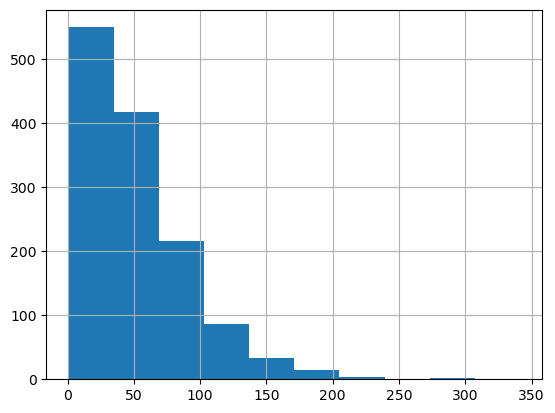

In [51]:
df_subs_count.subs_count.hist()

In [ ]:
# Создаем датафрейм для распределения подписчиков по регионам
df_subs_count = df_hwe_copy.query('flag == "1"').groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})

# Создаем scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_subs_count, x='LON', y='LAT', hue='subs_count', cmap='cool', s=80, alpha=0.8)

In [ ]:
#добавляем интерактив
# Создаем датафрейм для распределения подписчиков по регионам
df_subs_count = df_hwe_copy.query('flag == "1"').groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})
# Создаем карту
m = folium.Map(location=[df_subs_count['LAT'].mean(), df_subs_count['LON'].mean()], zoom_start=5)
# Создаем точечные маркеры для каждой точки и добавляем их на карту
for i, row in df_subs_count.iterrows():
    if row['subs_count'] > 250:
        color = 'red'
    elif row['subs_count'] > 150 and row['subs_count'] < 250:
        color = 'blue'
    else:
        color = 'green'
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=row['subs_count']/20,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=str(row['subs_count'])
    ).add_to(m)
m.save("HWE.html")